# Clustering space

In this tutorial, we will explore how to run the Supervised clustering, unsupervised clustering, and amortized Latent Dirichlet Allocation (LDA) model implementation in `omicverse` with `GaussianMixture`,`Leiden/Louvain` and `MiRA`. 

In scRNA-seq data analysis, we describe cellular structure in our dataset with finding cell identities that relate to known cell states or cell cycle stages. This process is usually called cell identity annotation. For this purpose, we structure cells into clusters to infer the identity of similar cells. Clustering itself is a common unsupervised machine learning problem. 

LDA is a topic modelling method first introduced in the natural language processing field. By treating each cell as a document and each gene expression count as a word, we can carry over the method to the single-cell biology field.

Below, we will train the model over a dataset, plot the topics over a UMAP of the reference set, and inspect the topics for characteristic gene sets.

## Preprocess data

As an example, we apply differential kinetic analysis to dentate gyrus neurogenesis, which comprises multiple heterogeneous subpopulations.

Colab_Reproducibility：https://colab.research.google.com/drive/1d_szq-y-g7O0C5rJgK22XC7uWTUNrYpK?usp=sharing

In [1]:
import omicverse as ov
import scanpy as sc
import scvelo as scv
ov.utils.ov_plot_set()


   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.5.2, Tutorials: https://omicverse.readthedocs.io/


In [2]:
import scvelo as scv
adata=scv.datasets.dentategyrus()
adata

AnnData object with n_obs × n_vars = 2930 × 13913
    obs: 'clusters', 'age(days)', 'clusters_enlarged'
    uns: 'clusters_colors'
    obsm: 'X_umap'
    layers: 'ambiguous', 'spliced', 'unspliced'

In [3]:
adata=ov.pp.preprocess(adata,mode='shiftlog|pearson',n_HVGs=3000,)
adata.raw = adata
adata = adata[:, adata.var.highly_variable_features]
ov.pp.scale(adata)
ov.pp.pca(adata,layer='scaled',n_pcs=50)

Begin robust gene identification
After filtration, 13264/13913 genes are kept. Among 13264 genes, 13189 genes are robust.
End of robust gene identification.
Begin size normalization: shiftlog and HVGs selection pearson
normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['Hba-a1', 'Malat1', 'Ptgds', 'Hbb-bt']
    finished (0:00:00)
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'highly_variable_nbatches', int vector (adata.var)
    'highly_variable_intersection', boolean vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'residual_variances', float vector (adata.var)
End of size normalization: shiftlog and HVGs selection pearson
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells. In our experience, often a rough estimate of the number of PCs does fine.

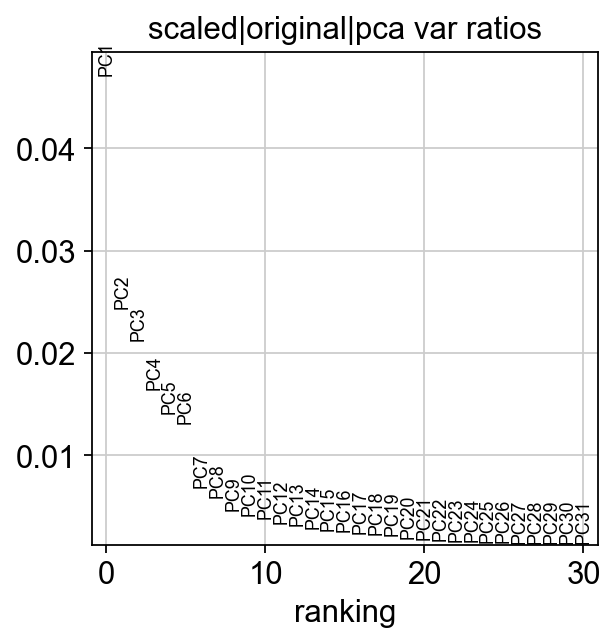

In [4]:
ov.utils.plot_pca_variance_ratio(adata)

## Unsupervised clustering

The Leiden algorithm is as an improved version of the Louvain algorithm which outperformed other clustering methods for single-cell RNA-seq data analysis ([Du et al., 2018, Freytag et al., 2018, Weber and Robinson, 2016]). Since the Louvain algorithm is no longer maintained, using Leiden instead is preferred.

We, therefore, propose to use the Leiden algorithm[Traag et al., 2019] on single-cell k-nearest-neighbour (KNN) graphs to cluster single-cell datasets.

Leiden creates clusters by taking into account the number of links between cells in a cluster versus the overall expected number of links in the dataset. 

Here, we set `method='leiden'` to cluster the cells using `Leiden`


In [5]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50,
               use_rep='scaled|original|X_pca')
ov.utils.cluster(adata,method='leiden',resolution=1)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Leiden clustering
    finished: found 21 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


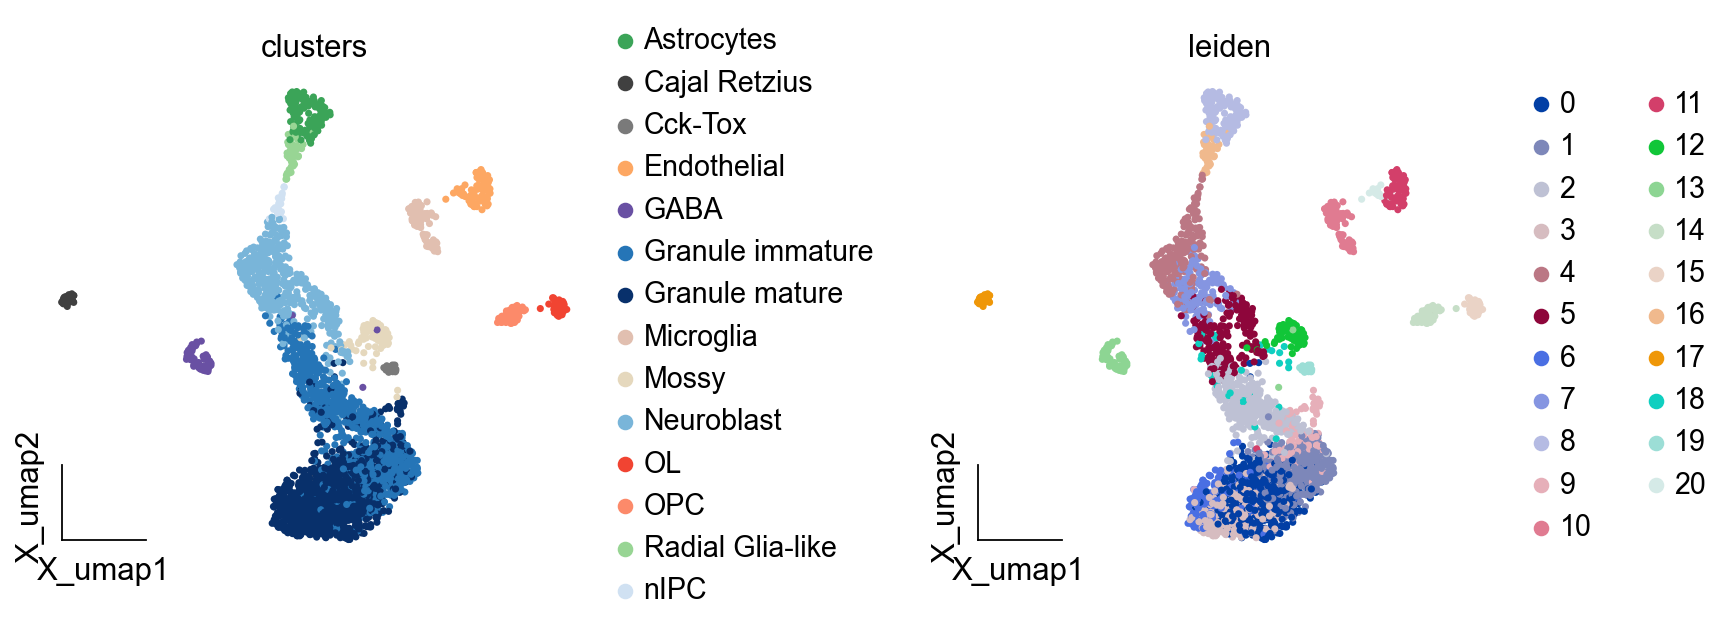

In [7]:
ov.utils.embedding(adata,basis='X_umap',
                   color=['clusters','leiden'],
                   frameon='small',wspace=0.5)

We can also set `method='louvain'` to cluster the cells using `Louvain`

In [8]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50,
               use_rep='scaled|original|X_pca')
ov.utils.cluster(adata,method='louvain',resolution=1)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 17 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


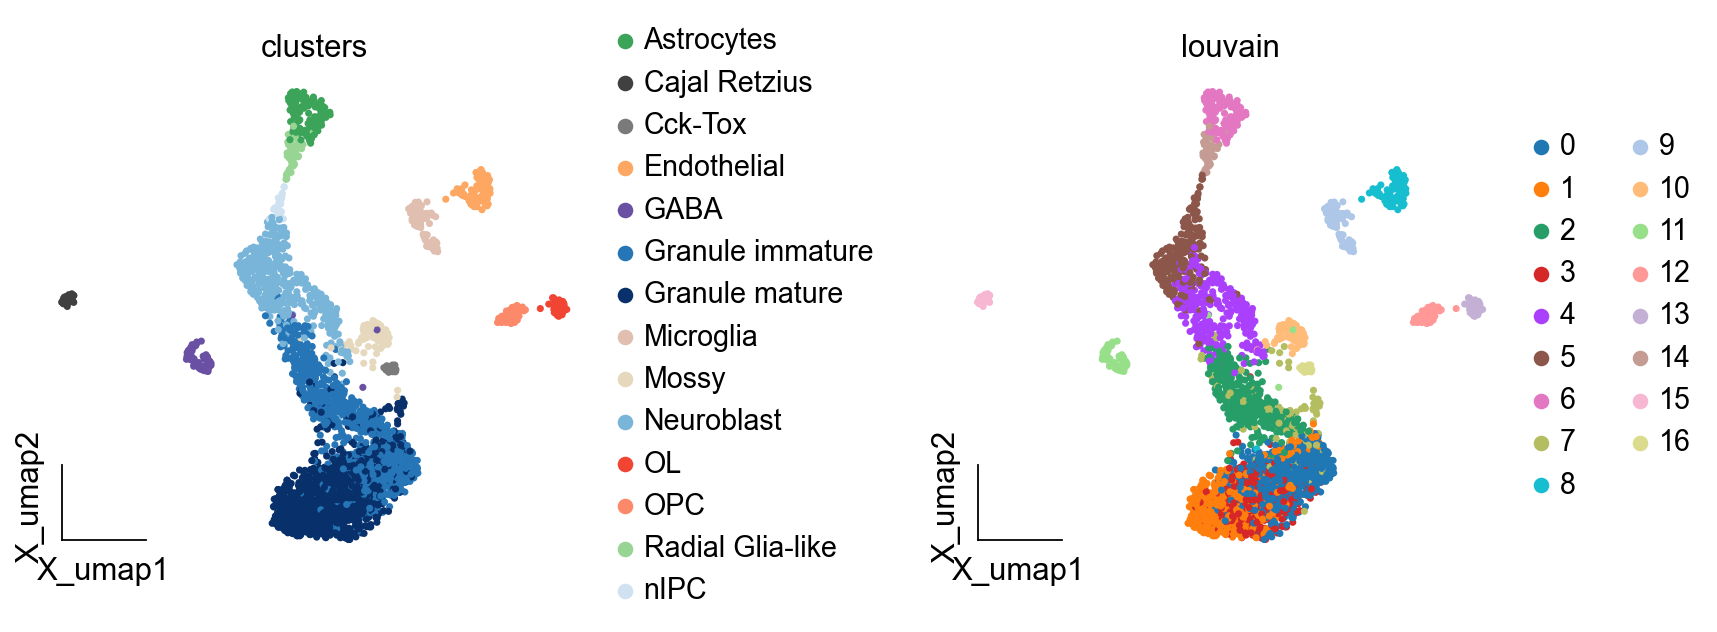

In [9]:
ov.utils.embedding(adata,basis='X_umap',
                   color=['clusters','louvain'],
                   frameon='small',wspace=0.5)

## Supervised clustering

In addition to clustering using unsupervised clustering methods, we can also try supervised clustering methods, such as Gaussian mixture model clustering, which is a supervised clustering algorithm that works better in machine learning

Gaussian mixture models can be used to cluster unlabeled data in much the same way as k-means. There are, however, a couple of advantages to using Gaussian mixture models over k-means.

First and foremost, k-means does not account for variance. By variance, we are referring to the width of the bell shape curve.

The second difference between k-means and Gaussian mixture models is that the former performs hard classification whereas the latter performs soft classification. In other words, k-means tells us what data point belong to which cluster but won’t provide us with the probabilities that a given data point belongs to each of the possible clusters.

Here, we set `method='GMM'` to cluster the cells using `GaussianMixture`,`n_components` means the PCs to be used in clustering, `covariance_type` means the Gaussian Mixture Models (`diagonal`, `spherical`, `tied` and `full` covariance matrices supported). More arguments could found in [`sklearn.mixture.GaussianMixture`](http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html)


In [10]:
ov.utils.cluster(adata,use_rep='scaled|original|X_pca',
                 method='GMM',n_components=21,
                 covariance_type='full',tol=1e-9, max_iter=1000, )

running GaussianMixture clustering
finished: found 21 clusters and added
    'gmm_cluster', the cluster labels (adata.obs, categorical)


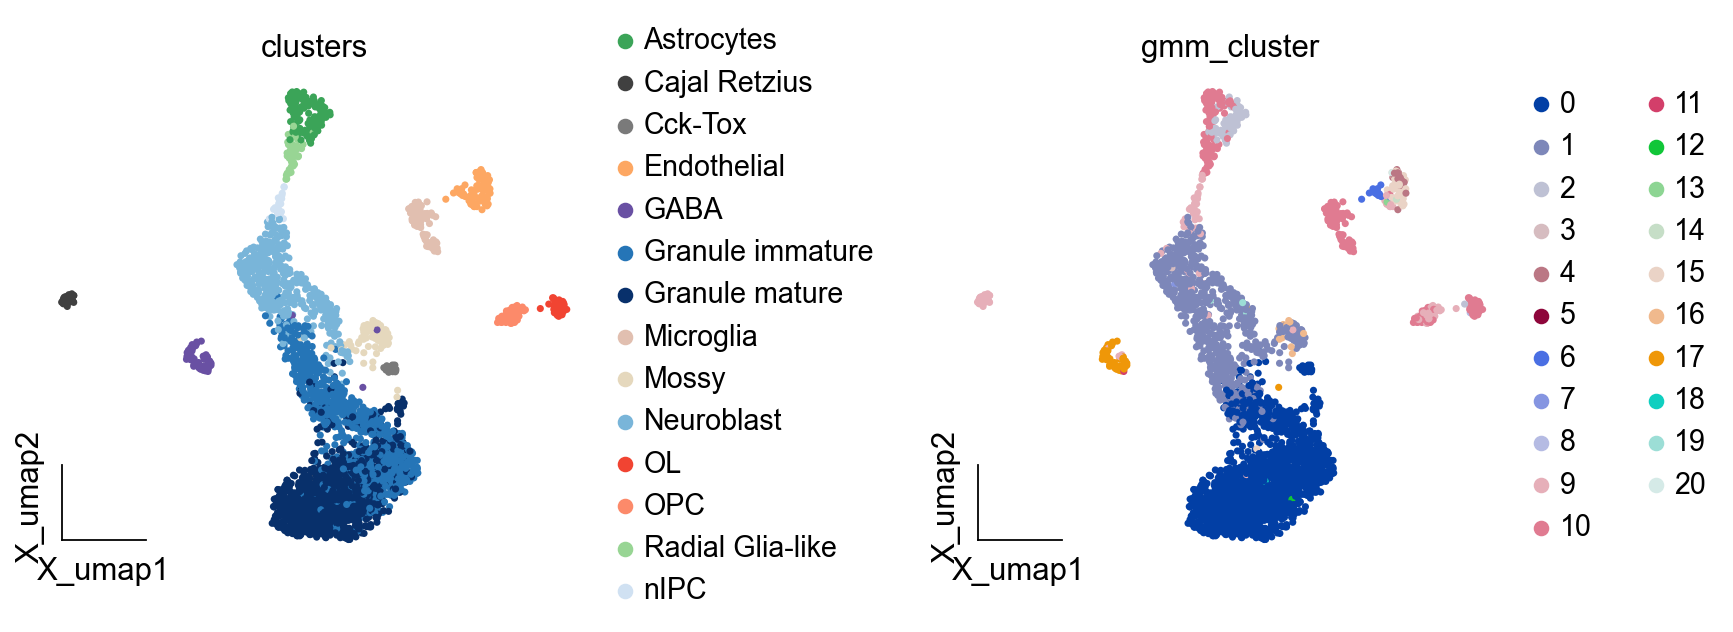

In [11]:
ov.utils.embedding(adata,basis='X_umap',
                   color=['clusters','gmm_cluster'],
                   frameon='small',wspace=0.5)

## Latent Dirichlet Allocation (LDA) model implementation

Topic models, like Latent Dirichlet Allocation (LDA), have traditionally been used to decompose a corpus of text into topics - or themes - composed of words that often appear together in documents. Documents, in turn, are modeled as a mixture of topics based on the words they contain.

MIRA extends these ideas to single-cell genomics data, where topics are groups of genes that are co-expressed or cis-regulatory elements that are co-accessible, and cells are a mixture of these regulatory modules. 

Here, we used `ov.utils.LDA_topic` to construct the model of MiRA.

Particularly, and at a minimum, we must tell the model

- feature_type: what type of features we are working with (either “expression” or “accessibility”)
- highly_variable_key: which .var key to find our highly variable genes
- counts_layer: which layer to get the raw counts from.
- categorical_covariates, continuous_covariates: Technical variables influencing the generative process of the data. For example, a categorical technical factor may be the cells’ batch of origin, as shown here. A continous technical factor might be % of mitchondrial reads. For unbatched data, ignore these parameters.
- learning_rate: for larger datasets, the default of 1e-3, 0.1 usually works well.

INFO:mira.adata_interface.topic_model:Predicting expression from genes from col: highly_variable_features


mira have been install version: 2.1.0


Learning rate range test:   0%|          | 0/98 [00:00<?, ?it/s]

INFO:mira.topic_model.base:Set learning rates to: (5.705129367383647e-06, 0.5595232820929605)


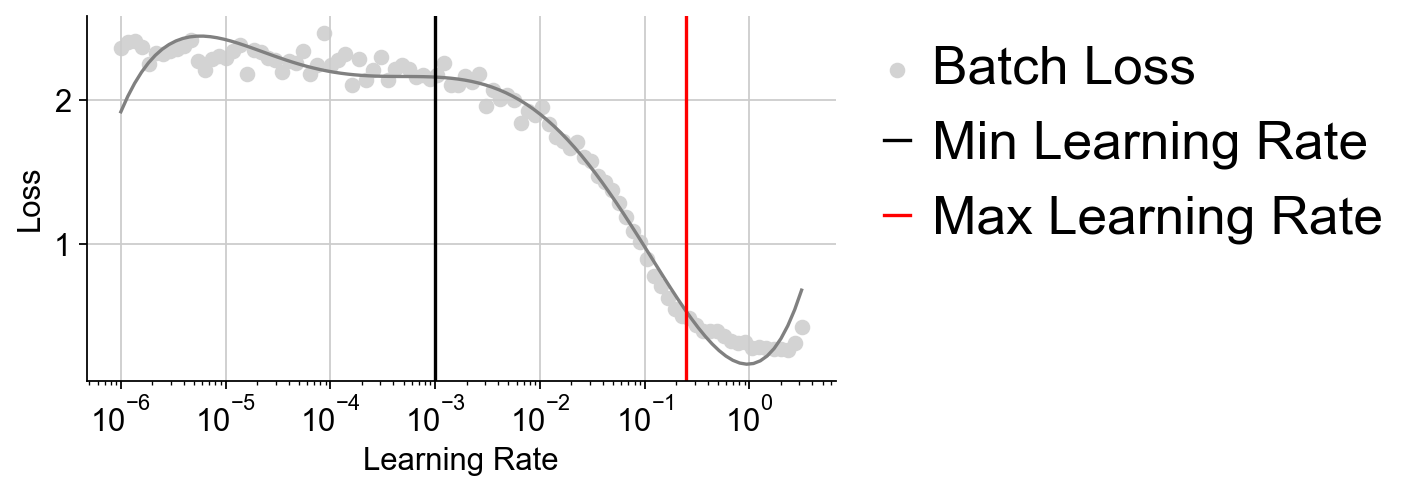

In [12]:
LDA_obj=ov.utils.LDA_topic(adata,feature_type='expression',
                  highly_variable_key='highly_variable_features',
                 layers='counts',batch_key=None,learning_rate=1e-3)

This method works by instantiating a special version of the CODAL model with far too many topics, which are gradually pruned if that topic is not needed to describe the data. The function returns the maximum contribution of each topic to any cell in the dataset. The predicted number of topics is given by the elbo of the maximum contribution curve, minus 1. A rule of thumb is that the last valid topic to include in the model is followed by a drop-off, after which all subsequent topics hover between 0.-0.05 maximum contributions.

We set `NUM_TOPICS` to six to try.

Training model:   0%|          | 0/24 [00:00<?, ?it/s]

Predicting latent vars:   0%|          | 0/12 [00:00<?, ?it/s]

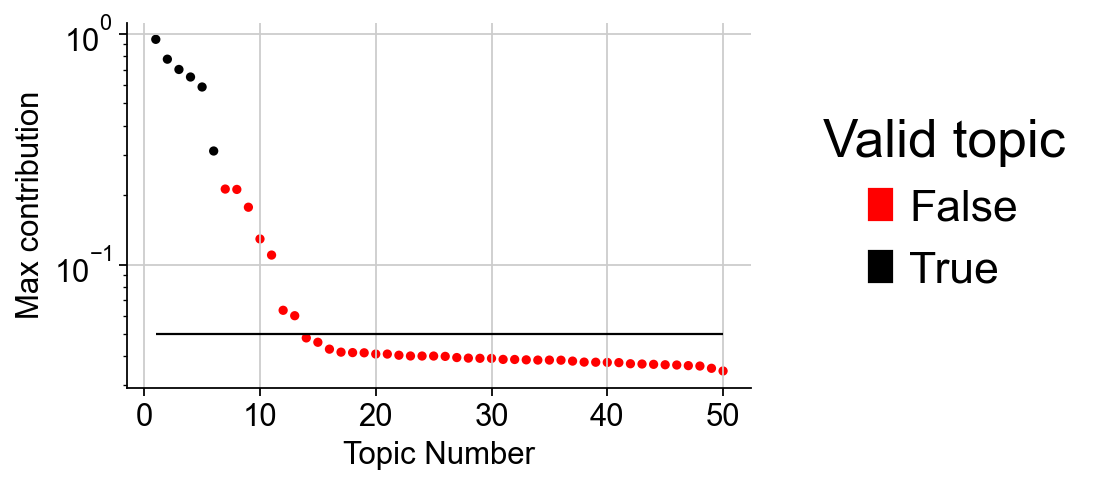

In [14]:
LDA_obj.plot_topic_contributions(6)

We can observe that there are 12 TOPICs to be above the threshold line, so we set the new NUM_TOPIC to 12

In [15]:
LDA_obj.predicted(12)

INFO:mira.adata_interface.topic_model:Predicting expression from genes from col: highly_variable_features


running LDA topic predicted


Training model:   0%|          | 0/24 [00:00<?, ?it/s]

INFO:mira.topic_model.base:Moving model to device: cpu


Predicting latent vars:   0%|          | 0/12 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.core:Added key to obsm: X_umap_features
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.topic_model:Added key to uns: topic_dendogram


finished: found 12 clusters and added
    'LDA_cluster', the cluster labels (adata.obs, categorical)


One can plot the distribution of topics across cells to see how the latent space reflects changes in cell state:

... storing 'LDA_cluster' as categorical


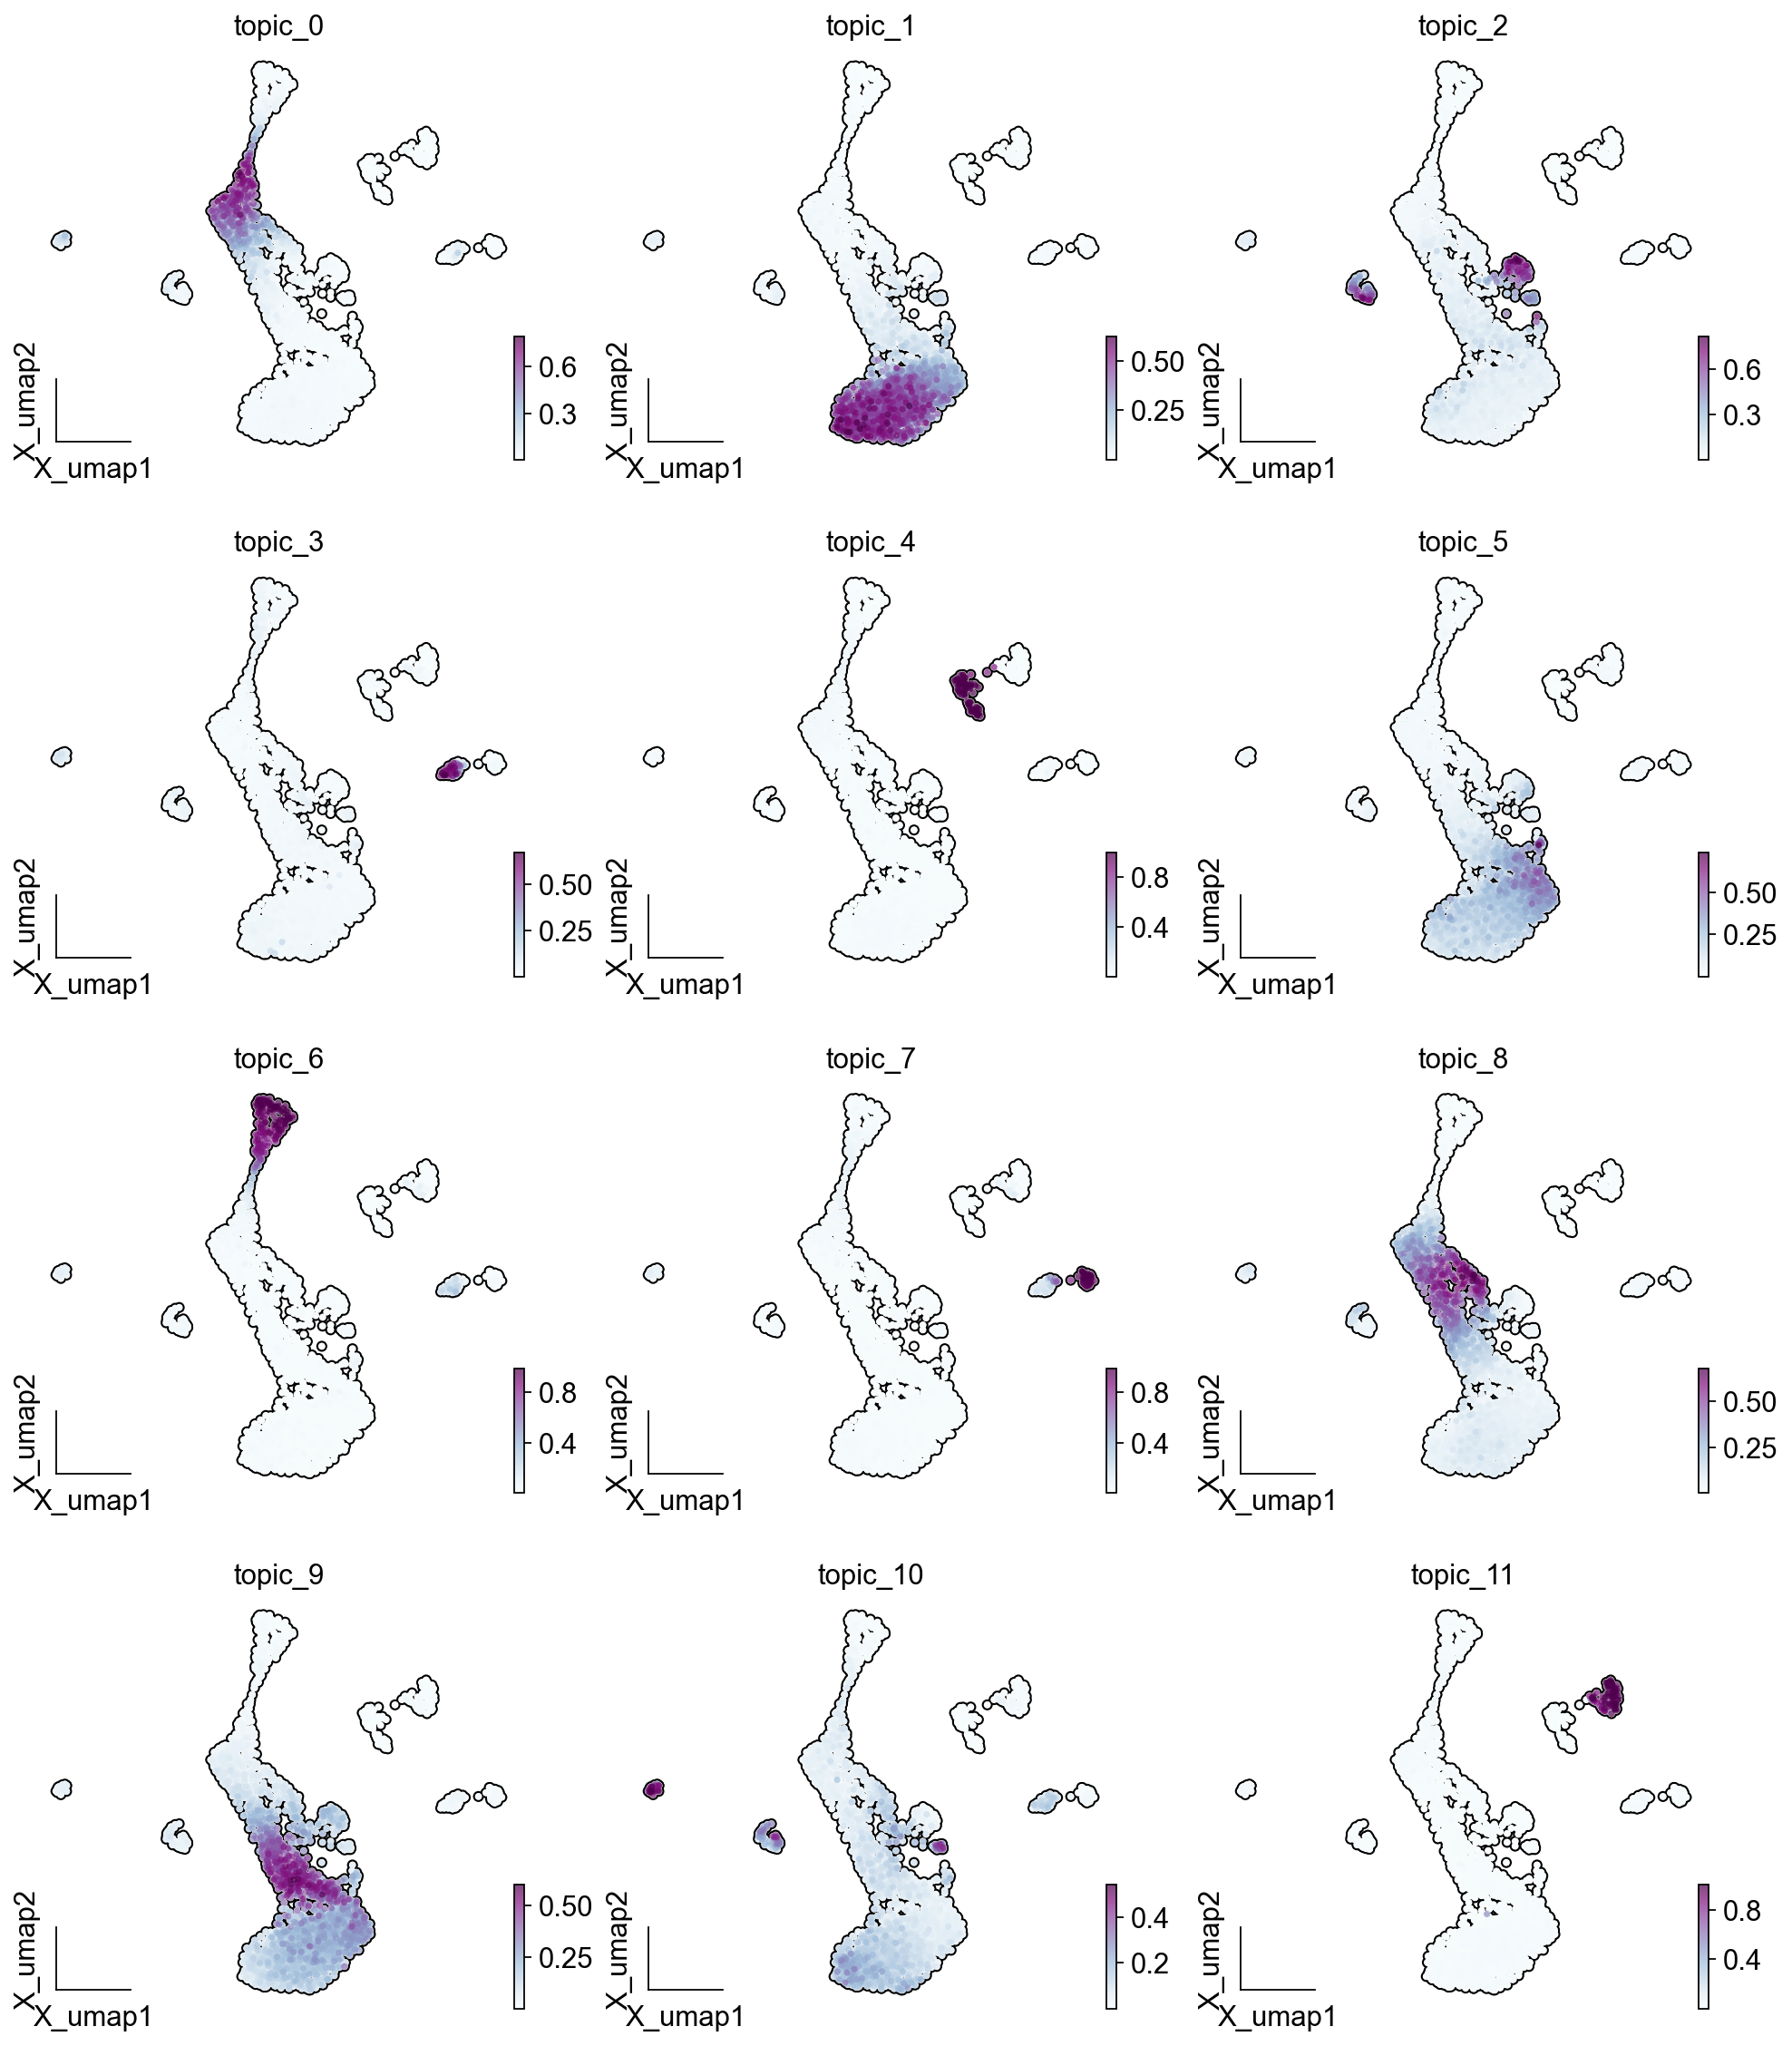

In [16]:
ov.utils.ov_plot_set()
ov.utils.embedding(adata, basis='X_umap',color = LDA_obj.model.topic_cols, cmap='BuPu', ncols=3,
           add_outline=True,  frameon='small',)

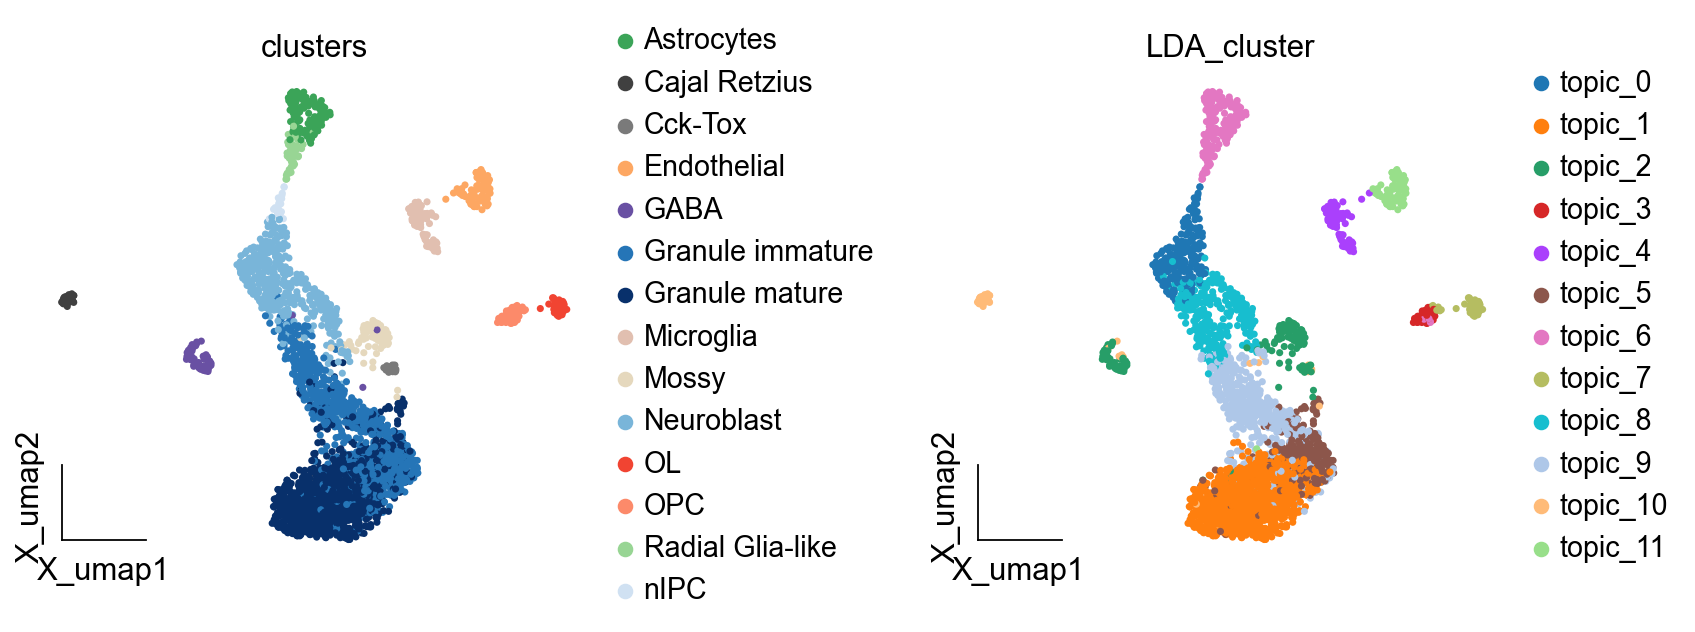

In [17]:
ov.utils.embedding(adata,basis='X_umap',
                   color=['clusters','LDA_cluster'],
                   frameon='small',wspace=0.5)

## Evaluation the clustering space

Rand index adjusted for chance. The Rand Index computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings.

In [18]:
from sklearn.metrics.cluster import adjusted_rand_score
ARI = adjusted_rand_score(adata.obs['clusters'], adata.obs['leiden'])
print('Leiden, Adjusted rand index = %.2f' %ARI)

ARI = adjusted_rand_score(adata.obs['clusters'], adata.obs['louvain'])
print('Louvain, Adjusted rand index = %.2f' %ARI)

ARI = adjusted_rand_score(adata.obs['clusters'], adata.obs['gmm_cluster'])
print('GMM, Adjusted rand index = %.2f' %ARI)

ARI = adjusted_rand_score(adata.obs['clusters'], adata.obs['LDA_cluster'])
print('LDA, Adjusted rand index = %.2f' %ARI)

Leiden, Adjusted rand index = 0.36
Louvain, Adjusted rand index = 0.38
GMM, Adjusted rand index = 0.49
LDA, Adjusted rand index = 0.54


We can find that the LDA topic model is the most effective among the above clustering algorithms, but it also takes the longest computation time and requires GPU resources. We notice that the Gaussian mixture model is second only to the LDA topic model. The GMM will be a great choice in omicverse's future clustering algorithms for spatial transcriptomics.